# Interactive Example

In [1]:
from gradio_client import Client
import obspy
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import json

/Users/weiqiang/.local/miniconda3/envs/gradio/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Prepare seismic waveforms

Find more details in obspy's tutorials: 

[FDSN web service client for ObsPy](https://docs.obspy.org/packages/obspy.clients.fdsn.html#module-obspy.clients.fdsn)

[Mass Downloader for FDSN Compliant Web Services](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.mass_downloader.html#module-obspy.clients.fdsn.mass_downloader)



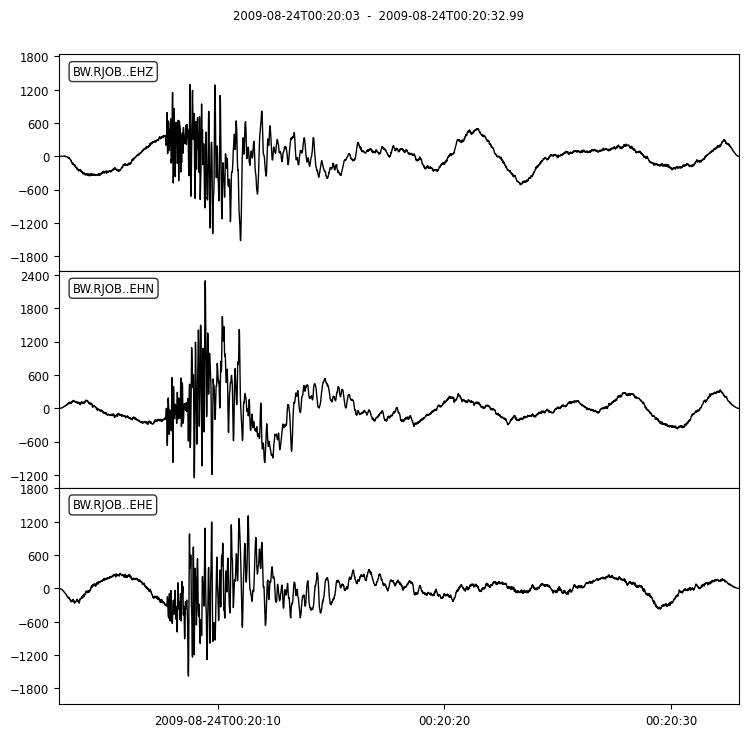

In [2]:
import obspy
stream = obspy.read()
stream.plot();

In [3]:
stream.write("data.mseed", format="MSEED")

In [4]:
## Extract 3-component data
stream = stream.sort()
assert(len(stream) == 3)
data = []
for trace in stream:
    data.append(trace.data)
data = np.array(data).T
assert(data.shape[-1] == 3)

data_id = stream[0].get_id()[:-1]
timestamp = stream[0].stats.starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]

## 3. Predict P/S-phase picks using PhaseNet

In [5]:
model = "ai4eps/phasenet"
# model = "http://127.0.0.1:7860"
client = Client(model, serialize=True)
_, picks_csv, picks_json = client.predict(["data.mseed"], json.dumps(data.tolist()), json.dumps([data_id]))

Loaded as API: http://127.0.0.1:7860/ ✔


In [7]:
picks = pd.read_json(picks_json)
# picks = pd.read_csv(csv, parse_dates=["phase_time"])
# print(picks)

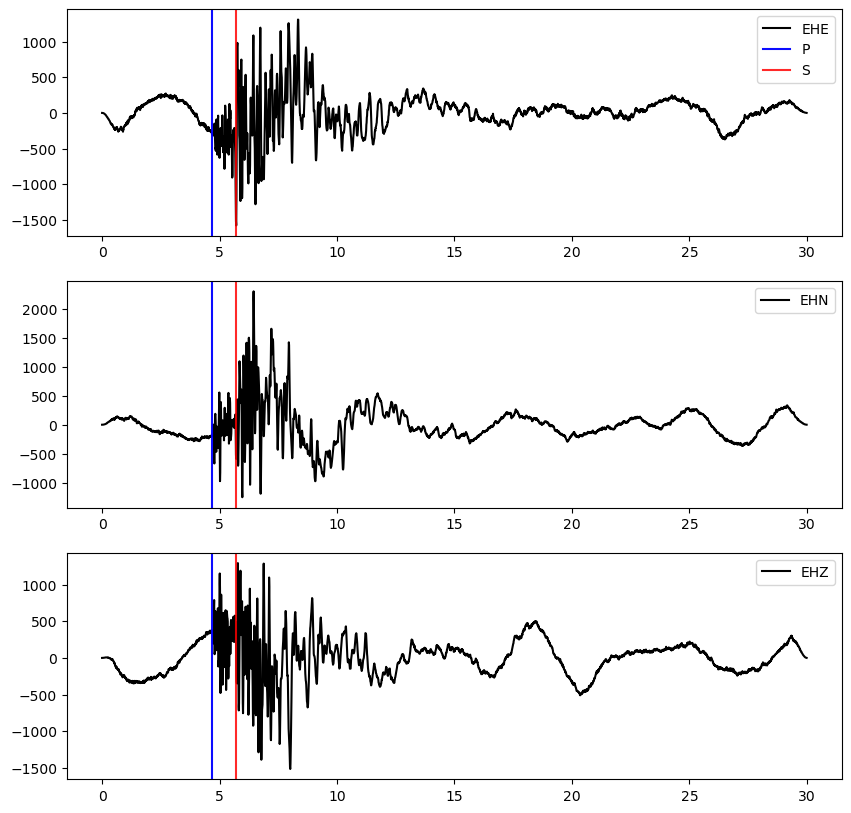

In [8]:
fig, ax = plt.subplots(len(stream), 1, figsize=(10, 10))
for i, tr in enumerate(stream):
    ax[i].plot(tr.times(), tr.data, label=tr.stats.channel, c="k")
    for _, pick in picks.iterrows():
        c = "blue" if pick["phase_type"] == "P" else "red"
        label = pick["phase_type"] if i == 0 else None
        ax[i].axvline((pick["phase_time"]-tr.stats.starttime.datetime).total_seconds(), c=c, label=label, alpha=pick["phase_score"])
    ax[i].legend()